# IR Project

Using ir_datasets
Source: https://ir-datasets.com/beir.html#beir/fiqa

In [1]:
import json, re
from google.colab import files

# Download current notebook as .ipynb (Colab provides it via the "notebook" internal)
# We'll fetch it by using the "Download .ipynb" flow, but programmatically we can just
# ask you to download after running this cleanup on a saved local file.

print("After running this cell: File → Download → Download .ipynb")
print("This method relies on Colab exporting a cleaned notebook once saved.")

After running this cell: File → Download → Download .ipynb
This method relies on Colab exporting a cleaned notebook once saved.


In [ ]:
!pip install --upgrade pip
!pip install python-terrier
!pip install matplotlib
!pip install seaborn
!pip install pyterrier_dr
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_t5.git

import pyterrier as pt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
import re
from pyterrier.measures import *
from pyterrier_dr import FlexIndex, SBertBiEncoder
from transformers import pipeline, AutoTokenizer
from pyterrier_alpha.fusion import RRFusion
from tqdm.auto import tqdm
from pyterrier_t5 import MonoT5ReRanker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 19.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s  0:00:00
  Created wheel for cbor: filename=cbor-1.0.0-cp312-cp312-linux_x86_64.whl size=55063 sha256=590e191bb853700b60762772de522d5ecd3fe31dbd95dfd6928df871273a6ab3
  Stored in directory: /root/.cache/pip/wheels/44/3e

# Dataset Collection

In [ ]:
dataset = pt.get_dataset('irds:beir/fiqa/test')

#documents
for doc in dataset.get_corpus_iter():
    print(doc.keys())
    print(doc)
    break

#queries
queries = dataset.get_topics()
print("\nDisplaying queries: ")
display(queries)

#qrels
qrels = dataset.get_qrels()
print("\nDisplaying qrels: ")
display(qrels)


[INFO] [starting] building docstore
[INFO] [starting] opening zip file
[INFO] If you have a local copy of https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/17918ed23cd04fb15047f73e6c3bd9d9
[INFO] [starting] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip
docs_iter:   0%|                                     | 0/57638 [00:01<?, ?doc/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip: 0.0%| 0.00/17.9M [00:00<?, ?B/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip: 0.2%| 32.8k/17.9M [00:00<01:19, 225kB/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip: 0.5%| 81.9k/17.9M [00:00<01:06, 270kB/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip: 1.1%| 197k/17.9M [00:00<00:41, 427kB/s] 
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/dat

beir/fiqa/test documents:   0%|          | 0/57638 [00:00<?, ?it/s]

[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]
[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]


dict_keys(['text', 'docno'])
{'text': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.", 'docno': '3'}

Displaying queries: 


,qid,query
0,4641,Where should I park my rainy-day / emergency f...
1,5503,Tax considerations for selling a property belo...
2,7803,Can the Delta be used to calculate the option ...
3,7017,Basic Algorithmic Trading Strategy
4,10152,What does a high operating margin but a small ...
...,...,...
643,4102,How can I determine if my rate of return is “g...
644,3566,Where can I buy stocks if I only want to inves...
645,94,Using credit card points to pay for tax deduct...
646,2551,How to find cheaper alternatives to a traditio...



Displaying qrels: 


,qid,docno,label,iteration
0,8,566392,1,0
1,8,65404,1,0
2,15,325273,1,0
3,18,88124,1,0
4,26,285255,1,0
...,...,...,...,...
1701,11039,330058,1,0
1702,11039,91183,1,0
1703,11054,155053,1,0
1704,11054,321015,1,0


In [ ]:
dataset = pt.get_dataset('irds:beir/fiqa/test')

In [ ]:
for doc in dataset.get_corpus_iter():
    print(doc.keys())
    print(doc)
    break

beir/fiqa/test documents:   0%|          | 0/57638 [00:00<?, ?it/s]

dict_keys(['text', 'docno'])
{'text': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.", 'docno': '3'}


In [ ]:

# Let us access some of the raw documents
for i, doc in enumerate(dataset.get_corpus_iter()):
    print(doc)
    if i == 9:
        break

beir/fiqa/test documents:   0%|          | 0/57638 [00:00<?, ?it/s]

{'text': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.", 'docno': '3'}
{'text': "So nothing preventing false ratings besides additional scrutiny from the market/investors, but there are some newer controls in place to prevent institutions from using them. Under the DFA banks can no longer solely rely on credit ratings as due diligence to buy a financial instrument, so that's a plus. The intent being that if financial institutions do their own leg work then *maybe* they'll figure out that a certain CDO is garbage or not.  Edit: lead in", 'docno': '31'}
{'text': "You can never us

In [ ]:
queries = dataset.get_topics()
display(queries)

,qid,query
0,4641,Where should I park my rainy-day / emergency f...
1,5503,Tax considerations for selling a property belo...
2,7803,Can the Delta be used to calculate the option ...
3,7017,Basic Algorithmic Trading Strategy
4,10152,What does a high operating margin but a small ...
...,...,...
643,4102,How can I determine if my rate of return is “g...
644,3566,Where can I buy stocks if I only want to inves...
645,94,Using credit card points to pay for tax deduct...
646,2551,How to find cheaper alternatives to a traditio...


# EDA

## EDA Documents

In [ ]:
# first create a dataframe from your iterator
docs = list(dataset.get_corpus_iter())
df = pd.DataFrame(docs)

# check what columns we have
print("Available columns:", df.columns.tolist())
print(f"\nTotal documents: {len(df)}")
print("\nFirst few documents:")
display(df.head())

df["text_length_words"] = df["text"].fillna("").apply(lambda x: len(x.split()))  # length in words

# basic statistics
print("Document Text Size Statistics")

print("\nWord Count Summary:")
print(df["text_length_words"].describe())

print("\nExamples:")
print(f"\nSmallest document (words): {df['text_length_words'].min()}")
print(f"Largest document (words): {df['text_length_words'].max()}")
print(f"Average document (words): {df['text_length_words'].mean():.2f}")


# extreme documents
print("Extreme Document Examples")

shortest_idx = df["text_length_words"].idxmin()
longest_idx  = df["text_length_words"].idxmax()

print("\nShortest document:")
print(f"docno:  {df.loc[shortest_idx, 'docno']}")
print(f"length: {df.loc[shortest_idx, 'text_length_words']} words")
print(df.loc[shortest_idx, 'text'])

print("\nLongest document:")
print(f"docno:  {df.loc[longest_idx, 'docno']}")
print(f"length: {df.loc[longest_idx, 'text_length_words']} words")
print(df.loc[longest_idx, 'text'][:1000], "...")

beir/fiqa/test documents:   0%|          | 0/57638 [00:00<?, ?it/s]

Available columns: ['text', 'docno']

Total documents: 57638

First few documents:


,text,docno
0,I'm not saying I don't like the idea of on-the...,3
1,So nothing preventing false ratings besides ad...,31
2,You can never use a health FSA for individual ...,56
3,Samsung created the LCD and other flat screen ...,59
4,Here are the SEC requirements: The federal sec...,63


Document Text Size Statistics

Word Count Summary:
count    57638.000000
mean       132.904473
std        128.738342
min          0.000000
25%         57.000000
50%         90.000000
75%        159.000000
max       2973.000000
Name: text_length_words, dtype: float64

Examples:

Smallest document (words): 0
Largest document (words): 2973
Average document (words): 132.90
Extreme Document Examples

Shortest document:
docno:  7915
length: 0 words


Longest document:
docno:  418057
length: 2973 words
"When considering such a major life decision, with such high potential costs and high potential rewards, I encourage you to consider multiple different potential options. Even if loans were available, they might not be the best option. Less debt and an engineering degree is better than more debt and an engineering degree, both of which are likely better than your current debt and no engineering degree. I encourage you to consider: revisit your aid (which is not just loans), cut expenses, consid

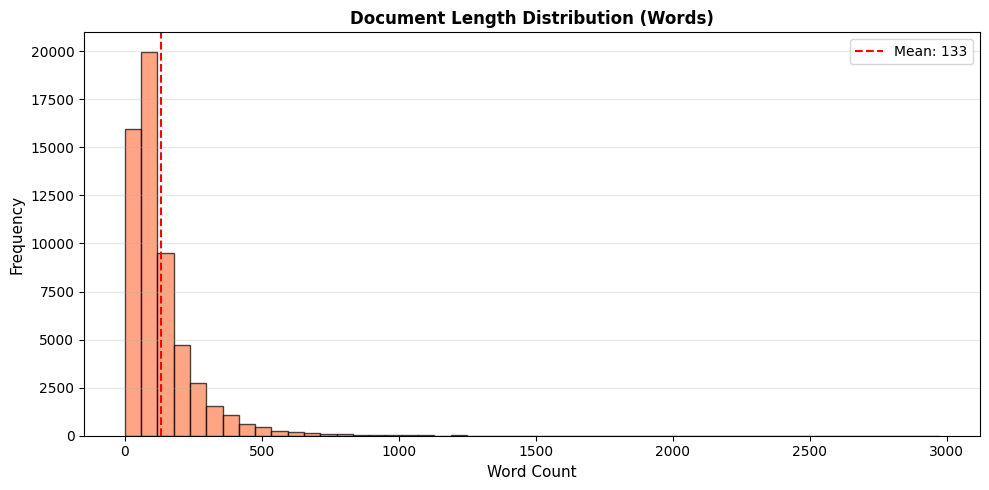

In [ ]:
# Visualize document text lengths
fig, ax = plt.subplots(figsize=(10, 5))

# Histogram - Word count
ax.hist(df["text_length_words"], bins=50, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Word Count', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Document Length Distribution (Words)', fontsize=12, fontweight='bold')
ax.axvline(df["text_length_words"].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length_words"].mean():.0f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## EDA Queries

Queries
Total queries: 648
Columns: ['qid', 'query']


,qid,query
0,4641,Where should I park my rainy-day / emergency f...
1,5503,Tax considerations for selling a property belo...
2,7803,Can the Delta be used to calculate the option ...
3,7017,Basic Algorithmic Trading Strategy
4,10152,What does a high operating margin but a small ...


Overall Statistics
count    648.000000
mean       2.632716
std        2.062616
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       15.000000
Name: docno, dtype: float64


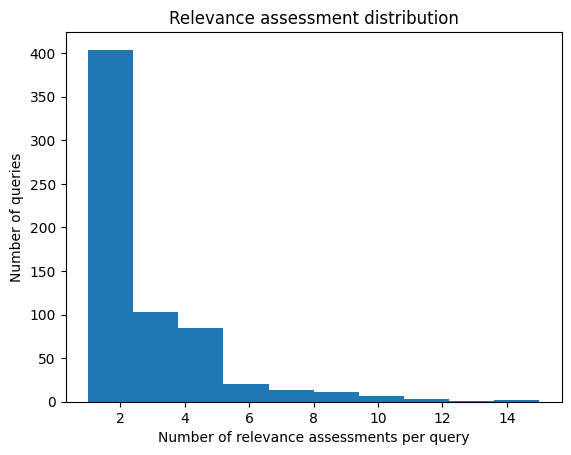

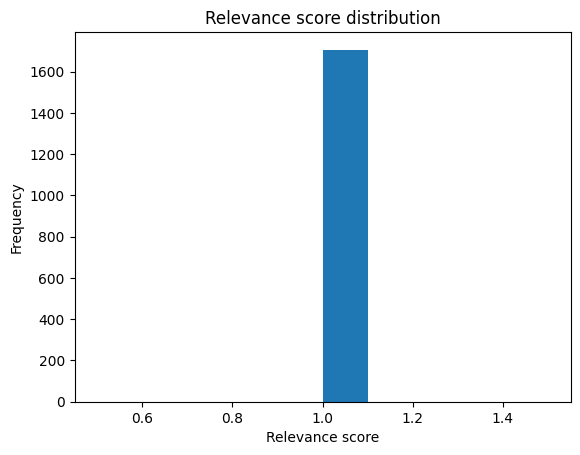

In [ ]:
print("Queries")
print(f"Total queries: {len(queries)}")
print(f"Columns: {queries.columns.tolist()}")

display(queries.head(5))
# Count how many relevance assessments each query has
counts = qrels.groupby("qid")["docno"].count()  # group by query id and count documents
print("Overall Statistics")
print(counts.describe())  # show a summary of the count distribution


# Plot how many relevance assessments each query received
plt.figure()  # create a new figure
counts.plot(kind="hist")  # histogram showing distribution of judgment counts
plt.xlabel("Number of relevance assessments per query")  # label for x-axis
plt.ylabel("Number of queries")  # label for y-axis
plt.title("Relevance assessment distribution")  # title of the plot
plt.show()  # display the plot

# Show the queries with the highest number of relevance assessments
counts.sort_values(ascending=False).head()  # top queries by number of judgments

# Count how many times each relevance label occurs overall
qrels["label"].value_counts()  # distribution of relevance scores

# Plot the label distribution as a histogram
plt.figure()  # create a new figure
qrels["label"].plot(kind="hist")  # histogram of relevance labels
plt.xlabel("Relevance score")  # label for x-axis
plt.ylabel("Frequency")  # label for y-axis
plt.title("Relevance score distribution")  # title of the plot
plt.show()  # display the plot

## EDA Qrels

In [ ]:
# qrels
qrels = dataset.get_qrels()

print("Qrels")
print(f"Total qrels rows: {len(qrels)}")
print(f"Unique queries in qrels: {qrels['qid'].nunique()}")
print(f"Unique docs in qrels: {qrels['docno'].nunique()}")

# coverage
unique_queries_with_qrels = qrels["qid"].nunique()
total_queries = len(queries)
coverage_percentage = 100 * unique_queries_with_qrels / total_queries

print(f"\nCoverage: {unique_queries_with_qrels}/{total_queries} "
      f"({coverage_percentage:.1f}% of queries have qrels)")

# queries with/without qrels
queries_with_qrels_set = set(qrels["qid"].unique())
queries_all_set = set(queries["qid"].unique())
missing_qrels = sorted(list(queries_all_set - queries_with_qrels_set))

print(f"\nQueries without qrels: {len(missing_qrels)}")
if missing_qrels:
    print("Examples of queries without qrels:")
    for qid in missing_qrels[:10]:
        qtext = queries.loc[queries["qid"] == qid, "query"].values[0]
        print(f"  {qid}: {qtext}")
    if len(missing_qrels) > 10:
        print(f"  ... and {len(missing_qrels) - 10} more")

Qrels
Total qrels rows: 1706
Unique queries in qrels: 648
Unique docs in qrels: 1706

Coverage: 648/648 (100.0% of queries have qrels)

Queries without qrels: 0


# Dataset Cleaning

In [ ]:
# load all docs
docs = list(dataset.get_corpus_iter())
df = pd.DataFrame(docs)

# clean documents
print("Cleaning documents...")
df = df[df["text"].notna()]
df["text"] = df["text"].astype(str)
df = df[df["text"].str.strip().str.len() > 0]

# clean queries
print("Cleaning queries...")
queries = queries[queries["query"].notna()]
queries["query"] = queries["query"].astype(str)
queries = queries[queries["query"].str.strip().str.len() > 0]

# normalize query text
queries["query"] = (
    queries["query"]
        .str.replace(":", " ", regex=False)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
)

# clean qrels to be consistent with df and queries
qrels = qrels[qrels["docno"].isin(df["docno"])]
qrels = qrels[qrels["qid"].isin(queries["qid"])]

beir/fiqa/test documents:   0%|          | 0/57638 [00:00<?, ?it/s]

Cleaning documents...
Cleaning queries...


# Indexing

In [ ]:
# Initialize PyTerrier
if not pt.started():
    pt.init()

# Create or reset an index folder
index_path = "./terrier_index"
if os.path.exists(index_path):
    shutil.rmtree(index_path)
os.makedirs(index_path, exist_ok=True)

# Build the index
indexer_doc = pt.IterDictIndexer(
    index_path,
    meta={"docno": 20},            # store docno as metadata (up to 20 characters)
    text_attrs=["text"],           # which field(s) contain the text
    meta_reverse=["docno"],        # enable reverse lookup on docno
    pretokenised=False,
    fields=False,
    threads=1,
)

indexref = indexer_doc.index(df.to_dict(orient="records"))

# Reference to the index
index = pt.IndexFactory.of(indexref)
stats = index.getCollectionStatistics()
print("Index folder:", index_path)
print("Number of documents:", stats.getNumberOfDocuments())
print("Number of postings:", stats.getNumberOfPostings())
print("Number of tokens:", stats.getNumberOfTokens())
print("Number of unique terms:", stats.getNumberOfUniqueTerms())
print("Average document length:", stats.getAverageDocumentLength())

/tmp/ipython-input-3813604504.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-assemblies/5.11/terrier-assemblies-5.11-jar-with-dependenci…

Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-python-helper/0.0.8/terrier-python-helper-0.0.8.jar:   0%| …

Done


Java started and loaded: pyterrier.java.colab, pyterrier.java, pyterrier.java.24, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipython-input-3813604504.py:3: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


15:44:26.766 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (261825) - further warnings are suppressed
15:44:42.739 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer -- Indexed 1 empty documents
Index folder: ./terrier_index
Number of documents: 57600
Number of postings: 2714611
Number of tokens: 3783214
Number of unique terms: 51260
Average document length: 65.68079861111111


# Document Chunking Logic

In [ ]:
def chunk_documents_generator(docs_list, chunk_size=200):

    for doc in docs_list:
        text = doc['text']
        words = text.split()

        # Split into chunks of 'chunk_size' words
        chunks = [words[i:i+chunk_size] for i in range(0, len(words), chunk_size)]

        if not chunks:
            continue

        for i, chunk_words in enumerate(chunks):
            yield {
                # Create a composite docno: "docID%chunkID"
                "docno": f"{doc['docno']}%{i}",
                "text": " ".join(chunk_words),
            }


# Phase 1:


## BM25, TFIDF, Query Rewriting + BM25



In [ ]:
bm25 = pt.terrier.Retriever(indexref, wmodel="BM25")
tfidf = pt.terrier.Retriever(indexref, wmodel="TF_IDF")
bm25_rm3 = (pt.terrier.Retriever(indexref, wmodel="BM25")
          >> pt.rewrite.RM3(indexref)
          >> pt.terrier.Retriever(indexref, wmodel="BM25"))

In [ ]:
phase1_results = pt.Experiment(
    [tfidf, bm25, bm25_rm3], # Add the new model here
    queries,
    qrels,
    eval_metrics=["map", P@1, P@5, P@10, R@5, R@10, nDCG@5, nDCG@10],
    names=["TF_IDF", "BM25", "BM25_Rewritten"],
    baseline=1, # Setting BM25 (index 1) as the baseline to see if Rewriting improves it
    verbose=True
)

display(phase1_results)

pt.Experiment:   0%|          | 0/3 [00:00<?, ?system/s]

,name,map,P@1,P@5,P@10,R@5,R@10,nDCG@5,nDCG@10,map +,...,R@5 p-value,R@10 +,R@10 -,R@10 p-value,nDCG@5 +,nDCG@5 -,nDCG@5 p-value,nDCG@10 +,nDCG@10 -,nDCG@10 p-value
0,TF_IDF,0.209578,0.234568,0.108642,0.071142,0.249805,0.313278,0.231198,0.253309,212.0,...,0.387057,11.0,5.0,0.264615,25.0,17.0,0.555088,49.0,33.0,0.611473
1,BM25,0.210418,0.236111,0.106790,0.070370,0.247691,0.309708,0.230294,0.252634,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BM25_Rewritten,0.206510,0.220679,0.107099,0.067593,0.243568,0.303302,0.225140,0.245356,232.0,...,0.632964,37.0,51.0,0.454409,63.0,76.0,0.284750,90.0,116.0,0.091524


# Phase 2:

## Experiment 1: Hybrid BM25+BGE

In [ ]:
# 1. Initialize PyTerrier (using modern check)
if not pt.java.started():
    pt.init()

# 2. Load the BGE Model
# Using SBertBiEncoder as the "smart alias" for BGE
bge_model = SBertBiEncoder("BAAI/bge-base-en-v1.5", device="cuda")
print(bge_model)

# 3. Build/Load the FlexIndex
dense_index = FlexIndex('bge_fiqa_index.flex')

# Offline Indexing
offline_indexing_pipeline_bge = bge_model >> dense_index.indexer(mode="overwrite")

# Index your documents (all docs)
print("Starting indexing...")
offline_indexing_pipeline_bge.index(docs)
print("Indexing complete.")

# Online Retrieval (With Rewriting)

# 4. Define the BGE Instruction Transformer
# This prepends the required prompt to the query column
def add_bge_instruction(df):
    df_out = df.copy()
    instruction = "Represent this sentence for searching relevant passages: "
    df_out["query"] = instruction + df_out["query"]
    return df_out

query_rewriter = pt.apply.generic(add_bge_instruction)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SBertBiEncoder('BAAI/bge-base-en-v1.5')
Starting indexing...


indexing: 0dvec [00:00, ?dvec/s]

Indexing complete.


### BGE Pipeline

In [ ]:
# BGE pipeline
retrieval_pipeline_bge = bge_model >> dense_index.retriever()

neural_ir_res_q_bge = retrieval_pipeline_bge.transform(queries)
display(neural_ir_res_q_bge)

NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

,qid,query,query_vec,docno,docid,score,rank
0,4641,Where should I park my rainy-day / emergency f...,"[0.039059352, -0.024108464, 0.014804017, 0.044...",406219,39076,0.742897,0
1,4641,Where should I park my rainy-day / emergency f...,"[0.039059352, -0.024108464, 0.014804017, 0.044...",376148,36224,0.735597,1
2,4641,Where should I park my rainy-day / emergency f...,"[0.039059352, -0.024108464, 0.014804017, 0.044...",345428,33316,0.723120,2
3,4641,Where should I park my rainy-day / emergency f...,"[0.039059352, -0.024108464, 0.014804017, 0.044...",580025,55690,0.716787,3
4,4641,Where should I park my rainy-day / emergency f...,"[0.039059352, -0.024108464, 0.014804017, 0.044...",497993,47916,0.716714,4
...,...,...,...,...,...,...,...
647995,2399,Where do web sites get foreign exchange curren...,"[-0.0030347207, 0.029289428, 0.049154993, -0.0...",11122,1048,0.587797,995
647996,2399,Where do web sites get foreign exchange curren...,"[-0.0030347207, 0.029289428, 0.049154993, -0.0...",216433,20813,0.587772,996
647997,2399,Where do web sites get foreign exchange curren...,"[-0.0030347207, 0.029289428, 0.049154993, -0.0...",96674,9382,0.587744,997
647998,2399,Where do web sites get foreign exchange curren...,"[-0.0030347207, 0.029289428, 0.049154993, -0.0...",277544,26865,0.587700,998


### BGE + Instructions Query Prefix Pipeline

In [ ]:
# BGE + Instructions Query Prefix Pipeline
retrieval_pipeline_bge_rewritten = query_rewriter >> bge_model >> dense_index.retriever()

print("Running retrieval...")
neural_ir_res_q_bge_rewritten = retrieval_pipeline_bge_rewritten.transform(queries)
display(neural_ir_res_q_bge_rewritten.head())

Running retrieval...


NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

,qid,query,query_vec,docno,docid,score,rank
0,4641,Represent this sentence for searching relevant...,"[0.03376982, -0.033416566, 0.0090752505, 0.040...",376148,36224,0.675636,0
1,4641,Represent this sentence for searching relevant...,"[0.03376982, -0.033416566, 0.0090752505, 0.040...",497993,47916,0.666460,1
2,4641,Represent this sentence for searching relevant...,"[0.03376982, -0.033416566, 0.0090752505, 0.040...",406219,39076,0.652278,2
3,4641,Represent this sentence for searching relevant...,"[0.03376982, -0.033416566, 0.0090752505, 0.040...",253614,24501,0.648296,3
4,4641,Represent this sentence for searching relevant...,"[0.03376982, -0.033416566, 0.0090752505, 0.040...",44594,4309,0.635255,4


### Comparison of scores wrt BM25

In [ ]:
# Scaler for linear scoring
def _min_max(res):
    if res.empty: return res
    res = res.copy()
    mn, mx = res['score'].min(), res['score'].max()
    res['score'] = (res['score'] - mn) / (mx - mn) if mx > mn else 1.0
    return res
scaler = pt.apply.by_query(_min_max)

In [ ]:
# Hybrid (BM25 + BGE) using Linear Combination with scaling
linear_scaled = (bm25 % 1000 >> scaler) + (retrieval_pipeline_bge % 1000 >> scaler)

# Hybrid (BM25 + BGE) using Reciprocal Rank Fusion
rrf_hybrid = RRFusion(bm25, retrieval_pipeline_bge, k=60, num_results=1000)

In [ ]:
# Results Experiment 1

systems_exp1 = [bm25, retrieval_pipeline_bge, retrieval_pipeline_bge_rewritten, linear_scaled, rrf_hybrid]
names_exp1 = ["BM25", "BGE", "BGE (with Instruction)", "Hybrid (Linear Normalized)", "Hybrid (RRF)"]

results_exp1 = pt.Experiment(
    systems_exp1,
    queries,
    qrels,
    eval_metrics=["map", P@1, P@5, P@10, R@5, R@10, nDCG@5, nDCG@10],
    names=names_exp1,
    highlight="bold"
)

display(results_exp1)

/usr/local/lib/python3.12/dist-packages/pyterrier/_evaluation/_validation.py:43: UserWarning: Transformer Hybrid (Linear Normalized) (<pyterrier._ops.Sum object at 0x7e8c21703470>) at position 3 failed to validate: Cannot determine outputs for <pyterrier._ops.Sum object at 0x7e8c21703470> with inputs: ['qid', 'query'] - if your pipeline works, set validate='ignore' to remove this warning, or add transform_output method to the transformers in this pipeline to clarify how it works. See https://pyterrier.readthedocs.io/en/latest/troubleshooting/inspection.html for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/pyterrier/_evaluation/_validation.py:43: UserWarning: Transformer Hybrid (RRF) (<pyterrier_alpha.fusion.RRFusion object at 0x7e8c21701eb0>) at position 4 failed to validate: Cannot determine outputs for <pyterrier_alpha.fusion.RRFusion object at 0x7e8c21701eb0> with inputs: ['qid', 'query'] - if your pipeline works, set validate='ignore' to remove this warning, or

NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

,name,map,P@1,P@5,P@10,R@5,R@10,nDCG@5,nDCG@10
0,BM25,0.210418,0.236111,0.106790,0.070370,0.247691,0.309708,0.230294,0.252634
1,BGE,0.334822,0.388889,0.171605,0.110185,0.373849,0.457247,0.363043,0.391509
2,BGE (with Instruction),0.347504,0.395062,0.184259,0.112191,0.404397,0.480580,0.382735,0.406301
3,Hybrid (Linear Normalized),0.331388,0.367284,0.172222,0.111420,0.380137,0.472197,0.360711,0.392579
4,Hybrid (RRF),0.314225,0.348765,0.165123,0.107099,0.367176,0.460231,0.343518,0.374995


## Experiment 2

In [ ]:
# 1. Setup Model (Qwen 2.5 1.5B)
model_id = "Qwen/Qwen2.5-1.5B-Instruct"

# Check if a GPU is available, otherwise use CPU
device = 0 if torch.cuda.is_available() else -1

# Load tokenizer and set padding_side to 'left'
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.padding_side = 'left'

pipe = pipeline(
    "text-generation",
    model=model_id,
    tokenizer=tokenizer,
    device=device,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    trust_remote_code=True,
    batch_size=8  # Process 8 queries at a time
)

# Transformer 1: Technical Keywords
class LLMTechnicalExpander(pt.Transformer):
    def __init__(self, pipe, batch_size=8):
        self.pipe = pipe
        self.batch_size = batch_size

    def _create_prompt(self, query):
        return [
            {"role": "system", "content": "You are a financial IR assistant. Expand the query with technical synonyms, tickers, and metrics. Output ONLY keywords separated by spaces. No sentences."},
            {"role": "user", "content": f"Expand: {query}"}
        ]

    def transform(self, queries_df):
        prompts = [self._create_prompt(q) for q in queries_df['query']]
        print(f"LLM: Generating Technical Keywords for {len(queries_df)} queries...")

        outputs = []
        for i in range(0, len(prompts), self.batch_size):
            batch = prompts[i : i + self.batch_size]
            batch_out = self.pipe(batch, max_new_tokens=50, temperature=0.1, do_sample=False, return_full_text=False)
            outputs.extend(batch_out)

        res = queries_df.copy()
        # We append the expansion to the original query
        res["query"] = [f"{orig} {out[0]['generated_text'].strip()}" for orig, out in zip(queries_df["query"], outputs)]
        return res

# Transformer 2: HYDE - Hypothetical answers
class LLMHyDEExpander(pt.Transformer):
    def __init__(self, pipe, batch_size=8):
        self.pipe = pipe
        self.batch_size = batch_size

    def _create_prompt(self, query):
        return [
            {"role": "system", "content": "You are a financial analyst. Write a sentence hypothetical answer that answers this question."},
            {"role": "user", "content": f"Question: {query}"}
        ]

    def transform(self, queries_df):
        prompts = [self._create_prompt(q) for q in queries_df['query']]
        print(f"LLM: Generating HyDE Answers for {len(queries_df)} queries...")

        outputs = []
        for i in range(0, len(prompts), self.batch_size):
            batch = prompts[i : i + self.batch_size]
            batch_out = self.pipe(batch, max_new_tokens=100, temperature=0.7, do_sample=True, return_full_text=False)
            outputs.extend(batch_out)

        res = queries_df.copy()
        # HyDE works best by replacing the query with the hypothetical answer
        res["query"] = [out[0]['generated_text'].strip() for out in outputs]
        return res

tech_expander = LLMTechnicalExpander(pipe)
hyde_expander = LLMHyDEExpander(pipe)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cuda:0


### BGE Pipeline with LLM Rewritten Queries

In [ ]:
# BGE Pipeline with technical queries
retrieval_pipeline_bge_tech = tech_expander >> retrieval_pipeline_bge

# BGE Pipeline with Hypothetical Queries
retrieval_pipeline_bge_hyp = hyde_expander >> retrieval_pipeline_bge

# BGE Pipeline using Linear Combination with scaling
hybrid_bge =  (retrieval_pipeline_bge_rewritten % 1000 >> scaler) * 0.7 + (retrieval_pipeline_bge_tech % 1000 >> scaler) * 0.15 + (retrieval_pipeline_bge_hyp % 1000 >> scaler) * 0.15

In [ ]:
# BM25 + BGE (instructions + combo of the two rewritten queries) using Linear Combination
linear_bm25_bge = (bm25 % 1000 >> scaler) + (hybrid_bge % 1000 >> scaler)

In [ ]:
systems_bm25_bge = [retrieval_pipeline_bge_rewritten, hybrid_bge, linear_bm25_bge ]
names_bm25_bge   = ["BGE rewritten", "BGE instruction with combo of the 3 queries", "BM25 + BGE(rewritten Combo 3 queries)"]

results_bm25_bge = pt.Experiment(
    systems_bm25_bge,
    queries,
    qrels,
    eval_metrics=["map", P@1, P@5, P@10, R@5, R@10, nDCG@5, nDCG@10],
    names=names_bm25_bge,
    highlight="bold"
)

display(results_bm25_bge)

LLM: Generating Technical Keywords for 0 queries...
LLM: Generating HyDE Answers for 0 queries...
LLM: Generating Technical Keywords for 0 queries...
LLM: Generating HyDE Answers for 0 queries...


/usr/local/lib/python3.12/dist-packages/pyterrier/_evaluation/_validation.py:43: UserWarning: Transformer BM25 + BGE(rewritten Combo 3 queries) (<pyterrier._ops.Sum object at 0x7a80bd322e70>) at position 2 failed to validate: Cannot determine outputs for <pyterrier._ops.Sum object at 0x7a80bd322e70> with inputs: ['qid', 'query'] - if your pipeline works, set validate='ignore' to remove this warning, or add transform_output method to the transformers in this pipeline to clarify how it works. See https://pyterrier.readthedocs.io/en/latest/troubleshooting/inspection.html for more information.
  warn(


NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM: Generating Technical Keywords for 648 queries...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

LLM: Generating HyDE Answers for 648 queries...


NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

LLM: Generating Technical Keywords for 648 queries...


NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

LLM: Generating HyDE Answers for 648 queries...


NumpyRetriever scoring:   0%|          | 0/15 [00:00<?, ?docbatch/s]

,name,map,P@1,P@5,P@10,R@5,R@10,nDCG@5,nDCG@10
0,BGE rewritten,0.347504,0.395062,0.184259,0.112191,0.404397,0.480580,0.382735,0.406301
1,BGE instruction with combo of the 3 queries,0.360271,0.416667,0.182407,0.114660,0.401658,0.485930,0.389699,0.417577
2,BM25 + BGE(rewritten Combo 3 queries),0.333811,0.385802,0.175309,0.112654,0.386201,0.485162,0.365889,0.398774


### Document Chunking

In [ ]:
index_path = "bge_fiqa_chunks.flex"
if os.path.exists(index_path):
    shutil.rmtree(index_path)
dense_index = FlexIndex(index_path)

In [ ]:
# Creation and indexing of the chunks
def chunk_documents_generator(docs_list, chunk_size=250):
    for doc in docs_list:
        words = doc['text'].split()
        chunks = [words[i:i+chunk_size] for i in range(0, len(words), chunk_size)]
        for i, chunk_words in enumerate(chunks):
            yield {
                "docno": f"{doc['docno']}%{i}",
                "text": " ".join(chunk_words),
            }

print("Indexing documents in chunks...")
indexing_pipeline = bge_model >> dense_index.indexer()
indexing_pipeline.index(chunk_documents_generator(df.to_dict(orient="records")))

Indexing documents in chunks...


indexing: 0dvec [00:00, ?dvec/s]

FlexIndex('bge_fiqa_chunks.flex')

In [ ]:
# Chunk scoring aggregator
def aggregate_max_passage(res):
    if res.empty: return res
    res = res.copy()
    res['docno'] = res['docno'].str.split('%').str[0]
    best_scores = res.groupby(['qid', 'docno'])['score'].max().reset_index()
    best_scores = best_scores.sort_values(['qid', 'score'], ascending=[True, False])
    best_scores['rank'] = best_scores.groupby('qid').cumcount()
    return best_scores

max_passage_aggregator = pt.apply.generic(aggregate_max_passage)

In [ ]:
retriever_chunking_bge = bge_model >> dense_index.retriever(num_results=400)

In [ ]:
# BGE Pipeline components with Document Chunking
pipe_standard = query_rewriter >> retriever_chunking_bge
pipe_tech = tech_expander >> query_rewriter >> retriever_chunking_bge
pipe_hyde = hyde_expander >> query_rewriter >> retriever_chunking_bge

# Combined Hybrid Pipeline: (Standard * 0.7) + (Tech * 0.15) + (HyDE * 0.15)
hybrid_pipeline_bge_chunking = (
    (pipe_standard % 400 >> scaler) * 0.7 +
    (pipe_tech % 400 >> scaler) * 0.15 +
    (pipe_hyde % 400 >> scaler) * 0.15) >> max_passage_aggregator

In [ ]:
# BM25 + BGE (instructions + combo of the two rewritten queries + Docs Chunking) using Linear Combination
linear_bm25_bge_chunking = (bm25 % 1000 >> scaler) + (hybrid_pipeline_bge_chunking % 1000 >> scaler)

In [ ]:
print("Running Final Evaluation...")
results = pt.Experiment(
    [hybrid_pipeline_bge_chunking, linear_bm25_bge_chunking],
    queries,
    qrels,
    eval_metrics=["map", P@1, P@5, P@10, R@5, R@10, nDCG@5, nDCG@10],
    names=["BGE_Chunked_LLM", "BM25 + BGE_Chunked_LLM"],
    verbose=True
)

print("\nFinal Results:")
display(results)

Running Final Evaluation...
LLM: Generating Technical Keywords for 0 queries...
LLM: Generating Technical Keywords for 0 queries...


/usr/local/lib/python3.12/dist-packages/pyterrier/_evaluation/_validation.py:43: UserWarning: Transformer BGE_Chunked_LLM ((<pyterrier._ops.Sum object at 0x7e8bec2947a0> >> pt.apply.generic())) at position 0 failed to validate: Cannot determine outputs for (<pyterrier._ops.Sum object at 0x7e8bec2947a0> >> pt.apply.generic()) with inputs: ['qid', 'query'] - if your pipeline works, set validate='ignore' to remove this warning, or add transform_output method to the transformers in this pipeline to clarify how it works. See https://pyterrier.readthedocs.io/en/latest/troubleshooting/inspection.html for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/pyterrier/_evaluation/_validation.py:43: UserWarning: Transformer BM25 + BGE_Chunked_LLM (<pyterrier._ops.Sum object at 0x7e8bec297410>) at position 1 failed to validate: Cannot determine outputs for <pyterrier._ops.Sum object at 0x7e8bec297410> with inputs: ['qid', 'query'] - if your pipeline works, set validate='ignore' to re

pt.Experiment:   0%|          | 0/2 [00:00<?, ?system/s]

NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]

LLM: Generating Technical Keywords for 648 queries...


NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]

LLM: Generating HyDE Answers for 648 queries...


NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]

NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]

LLM: Generating Technical Keywords for 648 queries...


NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]

LLM: Generating HyDE Answers for 648 queries...


NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]


Final Results:


,name,map,P@1,P@5,P@10,R@5,R@10,nDCG@5,nDCG@10
0,BGE_Chunked_LLM,0.356942,0.408951,0.185494,0.114506,0.408808,0.491943,0.389972,0.415948
1,BM25 + BGE_Chunked_LLM,0.340965,0.401235,0.178395,0.112037,0.392606,0.480337,0.375391,0.403964


## Final Reranking

In [ ]:
monoT5 = MonoT5ReRanker() # loads castorini/monot5-base-msmarco by default

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# Create a lookup dictionary from your df
doc_lookup = df.set_index('docno')['text'].to_dict()

# Custom transformer to add text column
class TextAdder(pt.Transformer):
    def __init__(self, doc_dict):
        self.doc_dict = doc_dict

    def transform(self, res):
        res = res.copy()
        res['text'] = res['docno'].map(self.doc_dict)
        # Drop any rows where text is missing
        res = res.dropna(subset=['text'])
        return res

text_adder = TextAdder(doc_lookup)

In [ ]:
# Final Pipeline combining Hybrid BM25 + BGE_Chunked_LLM and Re-ranking using monoT5
mono_pipeline_chunking = linear_bm25_bge_chunking % 50 >> text_adder >> monoT5

In [ ]:
# Final Experiment over the complete pipeline
results = pt.Experiment(
    [mono_pipeline_chunking],
    queries,
    qrels,
    ["map", P@1, P@5, P@10, R@5, R@10, nDCG@5, nDCG@10],
    ["monoT5_chunking"],
    perquery=False
)

display(results)

LLM: Generating Technical Keywords for 0 queries...


/usr/local/lib/python3.12/dist-packages/pyterrier/_evaluation/_validation.py:43: UserWarning: Transformer monoT5_chunking ((<pyterrier._ops.Sum object at 0x7e8bec297410> >> RankCutoff(50) >> <__main__.TextAdder object at 0x7e8cc12c9a00> >> MonoT5(castorini/monot5-base-msmarco))) at position 0 failed to validate: Cannot determine outputs for (<pyterrier._ops.Sum object at 0x7e8bec297410> >> RankCutoff(50) >> <__main__.TextAdder object at 0x7e8cc12c9a00> >> MonoT5(castorini/monot5-base-msmarco)) with inputs: ['qid', 'query'] - if your pipeline works, set validate='ignore' to remove this warning, or add transform_output method to the transformers in this pipeline to clarify how it works. See https://pyterrier.readthedocs.io/en/latest/troubleshooting/inspection.html for more information.
  warn(


NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]

LLM: Generating Technical Keywords for 648 queries...


NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]

LLM: Generating HyDE Answers for 648 queries...


NumpyRetriever scoring:   0%|          | 0/17 [00:00<?, ?docbatch/s]

monoT5:   0%|          | 0/8100 [00:00<?, ?batches/s]

,name,map,P@1,P@5,P@10,R@5,R@10,nDCG@5,nDCG@10
0,monoT5_chunking,0.356129,0.408951,0.185802,0.115895,0.416733,0.498445,0.395516,0.421252
